# Prototyping the egun mode for the Sirepo interface and demoing the Impact Density Report

**8/15/2017**

Updated the notebook for properly following particle trajectories. The steps required are as follows:

1. Set `top.ssnpid = ` during the specification of injection parameters
2. Run Warp in egun (or other) modes.
3. Grab the list of UNIQUE SSN values from `top.pgroup` via `pids = np.unique(top.pgroup.pid)`
4. Select the particles you'd like to plot - trajectories must be extracted one at a time due to variations in the number of data points for a given particle:
   e.g. one_particle_x_trajectory = getx()[selectparticles(ssn=ID)] - here ID is the integer SSN value of a particle
5. Section [Particle Trace Diagnostic](#PatricleTrace) provides an example
    

**7/27/2017**
Nathan Cook

This notebook provides a template for using the egun mode in the WarpVND interface. Use of egun mode requires three specific adjustments to Warp's traditional run mode:

1. Constant (inject=1) emission must be specified. In order to emit particles with the appropriate thermionic velocity and phase space, several additional flags in Warp must be specified:
    
    - vthz = thermal spread in z-velocities
    - vthperp = thermal spread in perpendicular (x) velocities
    - lhalfmaxwellinject = 1 -> specifies that no particles be injected with $v_z$ < 0 allowing proper current emission

2. The `gun` command must be called instead of the traditional `step` command. I've gated this call with the `STEADY_STATE_MODE` flag. Unlike `step`, the gun command should be called explicitly for each iteration (e.g. `for num in range(num_iterations): gun()`). The `gun` command includes several optional arguments of note:

    - maxtime (float [3*transittime]) : the maxitum time (correspoinding to #steps*top.dt) that transpire before an iteration ends. Defaults to 3x the internally computed crossing time. For now, I think this is a fine default.
    - rhoparam (float [none]) : for multiple iterations, mixes previous solution into new solution to promote relaxation to steady state. Defaults to none. Probably shouldn't be messed around with yet.
    
3. Tracer particles cannot be used at the same time as this mode, and therefore we cannot construct the particle trace diagnostic the same way. Look to the above note for a suggested solution.

At the bottom of the notebook, I discuss and demonstrate the new Impact Density Report, which provides color-normalized heat diagrams of where particles are lost in the simulation. This report can be used in any mode.

#### Table of Contents

[Diagnostics](#Diagnostics)

[Grid Parameters](#Grid_parameters)

[Solver Geometry and Boundaries](#Geometry)

[Source Parameterization](#Source)

[Source Defintions - NEW CODE](#Source_definitions)

[Solver Setup](#Solver)

[Conductor Installation](#Conductors)

[Diagnostics](#Diagnostics)

[Generate](#Generate)

[Run Simulation - NEW CODE](#Run_simulation)

[Particle Trace Diagnostic - NEW CODE](#PatricleTrace)

[Impact Density Report - NEW CODE](#ImpactDensity)

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
del sys.argv[1:] #  Necessry to run 'from warp import *' in IPython notebook without conflict.
from warp import * 
from warp.run_modes.egun_like import gun, gunppzx #needed for egun script
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import h5py
from re import findall
from scipy.special import erfinv
from datetime import datetime

import rswarp
from warp.data_dumping.openpmd_diag import ParticleDiagnostic
from rswarp.diagnostics import FieldDiagnostic
from rswarp.diagnostics import ConductorDiagnostics
from rswarp.utilities.file_utils import cleanupPrevious
from rswarp.utilities.file_utils import readparticles
from rswarp.utilities.file_utils import loadparticlefiles
from rswarp.cathode import sources
from rswarp.cathode import injectors
from warp.particles.singleparticle import TraceParticle


# Constants imports
from scipy.constants import e, m_e, c, k
from scipy.constants import c as clight
kb_eV = 8.6173324e-5 #Bolztmann constant in eV/K
kb_J = k #Boltzmann constant in J/K
m = m_e

/Users/ncook/.virtualenvs/rswarp_env/lib/python2.7/site-packages/warp/warp.py:79: UserWarning: there was an error importing gist; if this is a problem, restart python and type 'import gist' for details, otherwise Warp will run OK but with no graphics
  warnings.warn("there was an error importing gist; if this is a problem, restart python and type 'import gist' for details, otherwise Warp will run OK but with no graphics")


# Warp
# Origin date: Mon, 31 Jul 2017 16:16:12 -0600
# Local date: Mon, 31 Jul 2017 16:16:12 -0600
# Commit hash: 701976b
# /Users/ncook/.virtualenvs/rswarp_env/lib/python2.7/site-packages/warp/warp.pyc
# /Users/ncook/.virtualenvs/rswarp_env/lib/python2.7/site-packages/warp/warpC.so
# Tue Aug 15 17:45:37 2017
# import warp time 0.33886885643 seconds
# For more help, type warphelp()
The command to run is gun(iter,ipsave,save_same_part,maxtime).
For more info type doc(gun).
To do a proper restart, use the command restartgun(file).
To recover from a keyboard interrupt, use the command recovergun()
before doing more iterations.


## Diagnostics <a id='Diagnostics'></a>

In [3]:
diagDir = 'diags/xzsolver/hdf5/'
field_base_path = 'diags/fields/'
diagFDir = {'magnetic':'diags/fields/magnetic','electric':'diags/fields/electric'}

# Cleanup previous files
cleanupPrevious(diagDir,diagFDir)

## Grid parameters <a id='Grid_parameters'></a>

The grid parameters comprise one of the primary sets of user inputs, and are required for initializing the grid, pre-calculating fundamental currents, and generating the solver. These values are also used throuhgout visualization scripts.

**'Physical' Grid Parameters. These are physically intuitive values for a simple domain specification:**

1. `PLATE_SPACING` - The longitudinal distance (z-axis) between cathode and anode
2. `CHANNEL_WIDTH` - The transverse dimension of the simulation domain


**Technical Grid Parameters. These provide the required inputs for constructing simulation objects, but may be computed from the physical parameters above for a simple rectangular geometry:**

1. `X_MIN, X_MAX` - By default, horizontal domain is `(-0.5*CHANNEL_WIDTH,0.5*CHANNEL_WIDTH)`
2. `X_MIN, X_MAX` - By default, longitudinal domian is `[0, PLATE_SPACING]`
3. `Y_MIN, Y_MAX` - The ignorable plane, but specified for completeness. Defaults to +/- `(-0.5*CHANNEL_WIDTH,0.5*CHANNEL_WIDTH)`
4. `NUM_X` - The number of grid points along x.
5. `NUM_Y` - The number of grid points along y (ignorable for 2DXZ geometry).
6. `NUM_Z` - The number of grid points along z.


In [4]:
#GLOBAL GEOMETRY PARAMETERS FOR USERS
PLATE_SPACING = 1e-06
CHANNEL_WIDTH = 1e-07 #width of simulation box

#Dimensions
X_MAX = CHANNEL_WIDTH*0.5
X_MIN = -1.*X_MAX
Y_MAX = CHANNEL_WIDTH*0.5
Y_MIN = -1.*Y_MAX
Z_MIN = 0.
Z_MAX = PLATE_SPACING

#Grid parameters
NUM_X = 100
NUM_Y = 64
NUM_Z = 1000

#z step size
dz =  (Z_MAX - Z_MIN)/NUM_Z

## Solver Geometry and Boundaries <a id='Geometry'></a>

The solver geometry is a fundemental pre-requisite for any interface or simulation setup. We will assume for now that we are fixing a 2D X-Z geometry, with the Y axis as an ignorable plane. 

**`w3d.solvergeom = w3d.XZgeom`**

Future extensions to the interface will support 3D geometries. Where applicable and simple, small code snippets have been included in anticipation of this feature. However by no means are these scripts fully compliant with 3D simulations.

In [5]:
#Specify solver geometry
w3d.solvergeom = w3d.XZgeom

assert w3d.solvergeom == w3d.XZgeom, \
        'Solver geometry required to be w3d.XZgeom'

# Set boundary conditions
# Longitudinal conditions overriden by conducting plates
w3d.bound0  = neumann
w3d.boundnz = dirichlet
w3d.boundxy = periodic 
# Particles boundary conditions
top.pbound0  = absorb
top.pboundnz = absorb
top.pboundxy = periodic

# Set grid boundaries
w3d.xmmin = X_MIN
w3d.xmmax = X_MAX
w3d.zmmin = 0. 
w3d.zmmax = Z_MAX

# Set grid counts
w3d.nx = NUM_X
w3d.nz = NUM_Z

zmesh = np.linspace(0,Z_MAX,NUM_Z+1) #holds the z-axis grid points in an array

## Source parameterization <a id='Source'></a>

This section covers source parameterization, in particular how the electrons are emitted from the cathode. Warp permits several options. We want to support three options. For simplicity, I've defined the `USER_INJECT` flag which corresponds to the three possible options:

1. Constant emission - user specifies current. `USER_INJECT = 1`
2. Child-Langmuir emission (computed from geometries) - user selects and current is computed and displayed `USER_INJECT = 2`
3. thermionic emission (computed from cathode temperature) - user selects and current is computed and displayed `USER_INJECT = 3`

**Note that the following USER PARAMETERS are needed for the essential specification of the beam:**

1. Instantiation via species command i.e. `beam = Species(type=Electron, name='beam')`
2. beam radii in x,y via a0, b0 (`beam.a0 = 0.5*BEAM_WIDTH`). In many cases, `BEAM_WIDTH = CHANNEL_WIDTH`.
3. beam current (`beam.ibeam = BEAM_CURRENT`)
4. Cathode temperature in Kelvin (`CATHODE_TEMP`). Should default to 4K.
5. Minimum z-coordinate for injected particles (`Z_PART_MIN`). Must have `Z_PART_MIN > Z_MIN`.


**The next set of parameters are generated from additional user parameters (grid, beam, etc.):**

1. The injection type for the instance of `top` (`top.inejct = 6`). This will be set to 6 (user injection) for most cases, determined by the `USER_INJECT` switch.
2. Number of particles to be injected per step (`top.npinject`). This is computed from grid parameters and defaults to 10 particles per horizontal cell(e.g. `10*NUM_X`).
2. Injection coordinate determination - analytical vs. interpolated (`w3d.l_inj_exact`). Defaults to false for most injection types.
3. Variance of thermal particle velocity distribution in z (`beam.vthz`). Defaults to 0.
4. Variance of thermal particle velocity distribution in transverse plane (`beam.vthperp`). Defaults to 0.


The `rswarp` repository has been updated with a cathode module to streamline the designation of cathode sources via each of these three methods. Below we will demonstrate their use and provide a simple template.

In [6]:
#Cathode and anode settings
CATHODE_TEMP = 1273.15 #cathode temperature in K
CATHODE_PHI = 2.0 #work function in eV
ANODE_WF = 1.5
GRID_BIAS = 0 #voltage applied to any grid of electrodes

vacuum_level = CATHODE_PHI - ANODE_WF + GRID_BIAS
    
#compute beam cutoff velocity for time-step determinance
beam_beta = sources.compute_cutoff_beta(CATHODE_TEMP)

#Compute Child-Langmuir limit for this setup A/m^2
cl_limit = sources.cl_limit(CATHODE_PHI, ANODE_WF, GRID_BIAS, PLATE_SPACING)

In [7]:
#INJECTION SPECIFICATION
USER_INJECT = 1

# --- Setup simulation species
beam = Species(type=Electron, name='beam')

# --- Set basic beam parameters
SOURCE_RADIUS_1 = 0.5*CHANNEL_WIDTH #a0 parameter - X plane
SOURCE_RADIUS_2 = 0.5*CHANNEL_WIDTH #b0 parameter - Y plane
Z_PART_MIN = dz/8. #starting particle z value


#Compute cathode area for geomtry-specific current calculations
if (w3d.solvergeom == w3d.XYZgeom):
    #For 3D cartesion geometry only
    cathode_area = 4.*SOURCE_RADIUS_1*SOURCE_RADIUS_2
else:
    #Assume 2D XZ geometry
    cathode_area = 2.*SOURCE_RADIUS_1*1. # 1 m is the geometric factor scaling the plane of the ignorable coordinate        
      
#Set a default 'USER_CURRENT' to the Richardson-Dushman current in case of user-specified constant emission
#This will ultimately be an adjustable GUI parameter.
USER_CURRENT = cl_limit*cathode_area #sources.j_rd(CATHODE_TEMP,CATHODE_PHI)*cathode_area 

# If true, position and angle of injected particle are computed analytically rather than interpolated
# Can be false for all but C-L injection (inject=2)
w3d.l_inj_exact = False 

#Specify particles to be injected each step - 10 macro-particles per cell by default, USER SPECIFIED IN FUTURE
PTCL_PER_STEP = 10*NUM_X #fixed number for high resolution - running too many hogs memory #10*NUM_X
top.npinject = PTCL_PER_STEP

# --- If using the XZ geometry, set so injection uses the same geometry
top.linj_rectangle = (w3d.solvergeom == w3d.XZgeom)

#Determine an appropriate time step based upon estimated final velocity
vzfinal = sqrt(2.*abs(vacuum_level)*np.abs(beam.charge)/beam.mass)+beam_beta*c
dt = dz/vzfinal #5e-15
top.dt = dt

if vzfinal*top.dt > dz:
    print "Time step dt = {:.3e}s does not constrain motion to a single cell".format(top.dt)

# Source Definitions - modified for egun <a id='Source_definitions'></a> 

I've updated this code with the `top.ssnid = 1` flag to permit tracking.

In [8]:
# --- Sets method of running
# ---   Steady state gun mode
# ---   Time dependent simulation (when False)
STEADY_STATE_GUN = True

if STEADY_STATE_GUN:
    #We add these additional clarifications
    USER_INJECT = 1 

    #specify thermal properties
    beam.vthz     = np.sqrt(CATHODE_TEMP*kb_J/beam.mass)
    beam.vthperp  = np.sqrt(CATHODE_TEMP*kb_J/beam.mass)
    top.lhalfmaxwellinject = 1 #inject z velocities as half Maxwellian


if USER_INJECT == 1:
    # Constant current density - beam transverse velocity fixed to zero, very small longitduinal velocity
    
    #Set injection flag
    top.inject = 1               # 1 means constant; 2 means space-charge limited injection;# 6 means user-specified
    top.npinject = min(1000,NUM_X*10) #inject the minimum # of particles between 1000 and 10*the # of cells
    
    
    beam_current = 4./9.*eps0*sqrt(2.*echarge/beam.mass)*vacuum_level**1.5 / \
    PLATE_SPACING**2*cathode_area
    
    beam.ibeam = sources.j_rd(CATHODE_TEMP,CATHODE_PHI)*cathode_area #beam_current * 0.05
    beam.a0     = SOURCE_RADIUS_1
    beam.b0     = SOURCE_RADIUS_2
    beam.ap0      = .0e0
    beam.bp0      = .0e0
    w3d.l_inj_exact = True
    
    
if USER_INJECT == 2:
    # !WARNING - THIS DOES NOT GIVE THE RIGHT CURRENT - POSSIBLE BUG IN INJECTION CODE
    # space charge limited injection using Child-Langmuir computation of cold limit

    #Set injection flag
    top.inject = 2               # 1 means constant; 2 means space-charge limited injection;# 6 means user-specified
    top.npinject = 100
    
    beam_current = 4./9.*eps0*sqrt(2.*echarge/beam.mass)*vacuum_level**1.5 / \
    PLATE_SPACING**2*cathode_area
    
    
    beam.ibeam = beam_current
    beam.a0     = SOURCE_RADIUS_1
    beam.b0     = SOURCE_RADIUS_2    
    w3d.l_inj_exact = True
    
elif USER_INJECT == 3:
    # NOT TESTED WITH E-GUN MODE
    #Thermionic injection
    
    #Set injection flag
    top.inject = 6               # 1 means constant; 2 means space-charge limited injection;# 6 means user-specified   

    beam_current = sources.j_rd(CATHODE_TEMP,CATHODE_PHI)*cathode_area #steady state current in Amps
    beam.ibeam = beam_current
    beam.a0     = SOURCE_RADIUS_1
    beam.b0     = SOURCE_RADIUS_2
    
    myInjector = injectors.injectorUserDefined(beam, CATHODE_TEMP, CHANNEL_WIDTH, Z_PART_MIN, PTCL_PER_STEP)
    installuserinjection(myInjector.inject_thermionic_egun)
    
    # These must be set greater than or equal to the source radius for injection
    top.ainject = 1.0          
    top.binject = 1.0

#set the ssnpid
top.ssnpid = 1
    
derivqty()

## Create solver <a id='Solver'></a>

In [9]:
# Set up fieldsolver
f3d.mgtol = 1e-6 # Multigrid solver convergence tolerance, in volts. 1 uV is default in Warp.
solverE = MultiGrid2D()
registersolver(solverE)

## Install conductors <a id='Conductors'></a>

In [10]:
# Add a single post with biased grid element
# Sets anode voltage to 0 and add post/grid to scraper if true
install_grid = True

# --- Emitter settings
if install_grid:
    extractor_voltage = 0.
else:
    extractor_voltage = vacuum_level
# --- Anode Location
zplate = Z_MAX#1e-6 # --- plate location

# Create source conductors
source = ZPlane(zcent=w3d.zmmin,zsign=-1.,voltage=0.)
installconductor(source, dfill=largepos)

# Create ground plate
plate = ZPlane(voltage=extractor_voltage, zcent=zplate)
installconductor(plate,dfill=largepos)

#####

conductors = [
    Box(1e-08, 1., 1e-08, voltage=40, xcent=-2.5e-08, ycent=0.0, zcent=8.95e-07),
    Box(1e-08, 1., 1e-08, voltage=40, xcent=2.5e-08, ycent=0.0, zcent=8.95e-07),
    Box(1e-08, 1., 1e-08, voltage=-1, xcent=3.6e-08, ycent=0.0, zcent=7e-07),
    Box(1e-08, 1., 1e-08, voltage=-1, xcent=-3.6e-08, ycent=0.0, zcent=7e-07),
]

    

if install_grid:
    
    for c in conductors:
        if c.voltage != 0.0:
              installconductor(c)
    
    scraper = ParticleScraper([source, plate] + conductors, lcollectlpdata=True)
    scraper_dictionary = {1: 'source', 2: 'collector', 3: 'accel1', 4: 'accel2', 5: 'focus1', 6: 'focus2'}
    
else:
    # Setup the particle scraper
    scraper = ParticleScraper([source, plate])

## Define diagnostics <a id='Diagnostics'></a>

In [11]:
particleperiod = 100
particle_diagnostic_0 = ParticleDiagnostic(period = particleperiod, top = top, w3d = w3d,
                                          species = {species.name: species for species in listofallspecies},
                                          comm_world=comm_world, lparallel_output=False, write_dir = diagDir[:-5])
fieldperiod = 100
efield_diagnostic_0 = FieldDiagnostic.ElectrostaticFields(solver=solverE, top=top, w3d=w3d, comm_world = comm_world,
                                                          period=fieldperiod)

installafterstep(particle_diagnostic_0.write)
installafterstep(efield_diagnostic_0.write)

## UPDATED - Generate simulation package and plot potential
<a id='Generate'></a>
This call has been updated to allow for plotting of the electrostatic potential. Rather than calling generate with its default parameters, the `mgmaxiters` parameter is set to a large value (11000) to allow the initial solve called by generate to produce a potential that has converged to the geometry. After the `generate()` is finished, the parameter is reset to its default of 100.

In [12]:
#prevent GIST from starting upon setup
top.lprntpara = false
top.lpsplots = false

top.verbosity = 0 # Reduce solver verbosity 
solverE.mgverbose = 0 #further reduce output upon stepping - prevents websocket timeouts in Jupyter notebook

#Adjusting the multigrid parameter here improves convergence speed
#omega = 2./(1. + np.sin(np.pi/min(NUM_X+1,NUM_Z+1)))
#solverE.mgparam = omega

init_iters = 20000 
regular_iters = 1000

init_tol = 1e-6
regular_tol = 1e-6

solverE.mgmaxiters = init_iters
solverE.mgtol = init_tol
package("w3d")
generate()
solverE.mgtol = regular_tol
solverE.mgmaxiters = regular_iters

 ***  particle simulation package W3D generating
 ---  Resetting lattice array sizes
 ---  Allocating space for particles
 ---  Loading particles
 ---  Setting charge density
 ---  done
 ---  Allocating Win_Moments
 ---  Allocating Z_Moments
 ---  Allocating Lab_Moments


### Estimate the time of flight for an electron crossing the gap

We will estimate the average time of flight for a particle by averaging over the x-plane of the electric field, then integrating the particle motion in that averaged electric field. For our simulation particle we will take an electron with the expected velocity based on a thermal distribution with the cathode temperature.

**Note that this requires importing the interp1d function from scipy.interpolate**

In [13]:
from scipy.interpolate import interp1d as scipy_interp1d

#Grab Ez from the solver and average over the transverse (x) plane
Ez = solverE.getez()
flat_Ez = numpy.mean(Ez,0)

#Generate an interpolating function for smooth particle integration
Ez_approx = scipy_interp1d(zmesh,flat_Ez, kind='cubic')

#Integrate the particle motion subject to initial conditions specified by the simulation
tof_expected = sources.compute_expected_time(beam, CATHODE_TEMP, Ez_approx, Z_MIN, Z_MAX, top.dt)

print "Expected time of flight is {}s".format(tof_expected)
print "This corresponds to {} steps".format(tof_expected/top.dt)

Expected time of flight is 4.75814216213e-12s
This corresponds to 3698.0 steps


# Run simulation - This is new <a id='Run_simulation'></a>

In [14]:
ITERATIONS = 5 #number of iterations to run for steady state solver - Default to 5

for num in range(ITERATIONS):
    gun(1, ipstep=1, lvariabletimestep=1) #, maxtime=0.25*tof_expected)

 ***  particle simulation package W3D running
Number of particles injected for each species =  [1000]
29550 nplive =     1 zz = 0.0000zz = 0.0000nplive =  1000 zz = 0.0000zz = 0.0000zz = 0.0000zz = 0.0000nplive =   962 zz = 0.0000zz = 0.0000nplive =   840 zz = 0.0000nplive =   812 zz = 0.0000nplive =   783 zz = 0.0000nplive =   774 zz = 0.0000nplive =   699 zz = 0.0000zz = 0.0000nplive =   588 zz = 0.0000zz = 0.0000nplive =   369 zz = 0.0000nplive =   326 zz = 0.0000nplive =   319 zz = 0.0000zz = 0.0000nplive =   298 zz = 0.0000zz = 0.0000nplive =   270 zz = 0.0000nplive =   253 zz = 0.0000nplive =   253 zz = 0.0000nplive =   251 zz = 0.0000nplive =   240 zz = 0.0000nplive =   238 zz = 0.0000nplive =   238 zz = 0.0000nplive =   233 zz = 0.0000nplive =   224 zz = 0.0000zz = 0.0000nplive =   208 zz = 0.0000nplive =   197 zz = 0.0000nplive =   186 zz = 0.0000nplive =   184 zz = 0.0000nplive =   184 zz = 0.0000nplive =   183 zz = 0.0000nplive =   182 zz = 0.0000nplive =   176 zz = 0.0000zz

62790 nplive =     1 zz = 0.0000nplive =   999 zz = 0.0000nplive =   991 zz = 0.0000zz = 0.0000zz = 0.0000nplive =   871 zz = 0.0000zz = 0.0000nplive =   857 zz = 0.0000nplive =   820 zz = 0.0000zz = 0.0000zz = 0.0000nplive =   614 zz = 0.0000nplive =   565 zz = 0.0000nplive =   513 zz = 0.0000nplive =   372 zz = 0.0000nplive =   362 zz = 0.0000nplive =   343 zz = 0.0000nplive =   294 zz = 0.0000nplive =   263 zz = 0.0000nplive =   244 zz = 0.0000nplive =   244 zz = 0.0000nplive =   241 zz = 0.0000nplive =   231 zz = 0.0000nplive =   223 zz = 0.0000nplive =   217 zz = 0.0000nplive =   186 zz = 0.0000nplive =   185 zz = 0.0000zz = 0.0000nplive =   180 zz = 0.0000nplive =   166 zz = 0.0000nplive =   164 zz = 0.0000nplive =   144 zz = 0.0000nplive =   135 zz = 0.0000nplive =   128 zz = 0.0000nplive =   115 zz = 0.0000nplive =    95 zz = 0.0000zz = 0.0000zz = 0.0000nplive =    83 zz = 0.0000nplive =    80 zz = 0.0000nplive =    70 zz = 0.0000nplive =    63 zz = 0.0000zz = 0.0000zz = 0.0000

94020 nplive =     1 zz = 0.0000zz = 0.0000nplive =  1000 zz = 0.0000nplive =   995 zz = 0.0000nplive =   994 zz = 0.0000zz = 0.0000zz = 0.0000nplive =   900 zz = 0.0000nplive =   682 zz = 0.0000nplive =   605 zz = 0.0000nplive =   563 zz = 0.0000nplive =   560 zz = 0.0000nplive =   558 zz = 0.0000zz = 0.0000nplive =   404 zz = 0.0000zz = 0.0000nplive =   363 zz = 0.0000zz = 0.0000nplive =   291 zz = 0.0000nplive =   289 zz = 0.0000zz = 0.0000nplive =   256 zz = 0.0000nplive =   256 zz = 0.0000nplive =   255 zz = 0.0000nplive =   236 zz = 0.0000nplive =   234 zz = 0.0000nplive =   221 zz = 0.0000nplive =   215 zz = 0.0000zz = 0.0000nplive =   169 zz = 0.0000nplive =   155 zz = 0.0000nplive =   147 zz = 0.0000nplive =   131 zz = 0.0000nplive =   129 zz = 0.0000zz = 0.0000zz = 0.0000zz = 0.0000nplive =    87 zz = 0.0000nplive =    87 zz = 0.0000nplive =    85 zz = 0.0000nplive =    84 zz = 0.0000zz = 0.0000zz = 0.0000zz = 0.0000nplive =    68 zz = 0.0000zz = 0.0000nplive =    68 zz = 0.0

119440 nplive =     1 zz = 0.0000plive =  1000 zz = 0.0000zz = 0.0000zz = 0.0000zz = 0.0000nplive =  1000 zz = 0.0000nplive =  1000 zz = 0.0000zz = 0.0000nplive =   999 zz = 0.0000nplive =   998 zz = 0.0000nplive =   998 zz = 0.0000nplive =   964 zz = 0.0000nplive =   920 zz = 0.0000zz = 0.0000nplive =   831 zz = 0.0000zz = 0.0000nplive =   778 zz = 0.0000nplive =   723 zz = 0.0000zz = 0.0000nplive =   669 zz = 0.0000nplive =   652 zz = 0.0000nplive =   570 zz = 0.0000nplive =   540 zz = 0.0000nplive =   517 zz = 0.0000zz = 0.0000nplive =   459 zz = 0.0000zz = 0.0000nplive =   404 zz = 0.0000nplive =   354 zz = 0.0000nplive =   353 zz = 0.0000zz = 0.0000nplive =   310 zz = 0.0000zz = 0.0000nplive =   272 zz = 0.0000nplive =   270 zz = 0.0000nplive =   252 zz = 0.0000nplive =   220 zz = 0.0000zz = 0.0000nplive =   208 zz = 0.0000nplive =   193 zz = 0.0000nplive =   172 zz = 0.0000nplive =   170 zz = 0.0000nplive =   143 zz = 0.0000nplive =   141 zz = 0.0000zz = 0.0000zz = 0.0000nplive =

# Analysis <a id='Analysis'></a>

### Particle trace diagnostic<a id='PatricleTrace'></a>

Although Warp saves particle data, which is accessible via the `get(x/y/z)` commands, the data is unsorted, resulting in jumbled trajectories. In order to cleanly plot a few trajectories, particle SSN values must be acquires, and the appropriate selections must be made to grab individual particle coordinates during the simulation.

The following code provides an example of the procedure for correctly grabbing particle data for reconstructing their trajectories. The variable `NUM_TRAJECTORIES` has been set to limit the number of trajectories, since the plot can become quite complex with transverse velocities.

<IPython.core.display.Javascript object>


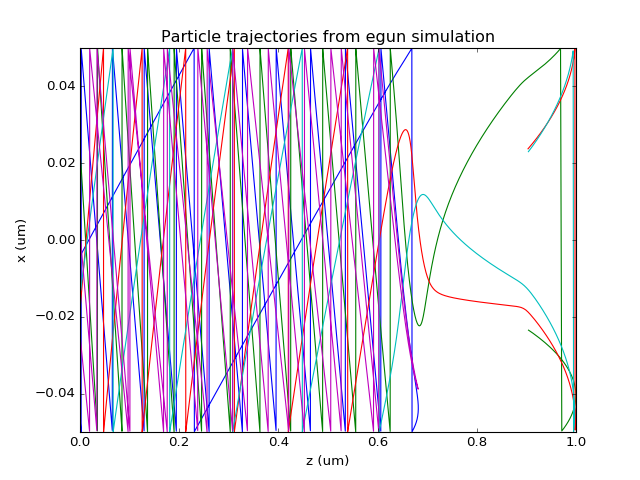

In [26]:
#Grab the list of valid IDs
pids = np.unique(top.pgroup.pid)

NUM_TRAJECTORIES = 5 #number of particle trajectories to plot

#Plot
figure = plt.figure()
ax = figure.gca()

scale = 1e6 #want to convert to microns
#get the positions for a select number of particles to be plotted
for ID in pids[:NUM_TRAJECTORIES]:
    xvals = getx()[selectparticles(ssn=int(ID))]*scale
    zvals = getz()[selectparticles(ssn=int(ID))]*scale

    ax.plot(zvals,xvals)

ax.set_ylim(X_MIN*scale,X_MAX*scale)
ax.set_xlabel('z (um)')
ax.set_ylabel('x (um)')

plt.title('Particle trajectories from egun simulation')
plt.show()
#plt.savefig('egun_traj10.png', bbox_inches='tight')

## Impact Density Report - This is new  <a id='ImpactDensity'></a>

Chris has developed a new impact density diagnostic, which can show where particles left the domain along the surface of different conductor using a normalized color-coordinated heat map. The diagnostic takes the form of a Python class, whose module can be found in `rswarp.diagnostics`.

The impact density class object is initialized with the call:

`IDP = ImpactDensity.PlotDensity(ax, cax, scraper, top, w3d)`

where input parameters are given as follows:

- `ax` - the subplot/axis object representing the simulation domain
- `cax` - the subplot/axis object representing the color scale
- `scraper` - the scraper object defined in Warp (e.g. `scraper = ParticleScraper([source, plate] + conductors, lcollectlpdata=True)`)
- `top` - the high level Warp object containing metadata and particle coordinates
- `w3d` - the high level Warp object containing grid and solver data for performing tracking routines

To construct the plot, you can simply call `IDP()`, which in turn chains the following commands:

- self.gate_scraped_particles()
- self.map_density()
- self.generate_plots()

Because the instantiation assumes axes objects have already been put in place, the example below wraps the IDP call about a traditional matplotlib figure call. I've used `matplotlib.gridspec` to proportionally frame the mesh plot and color bar to my tastes.

In [38]:
from rswarp.diagnostics import ImpactDensity
from matplotlib import gridspec

<IPython.core.display.Javascript object>


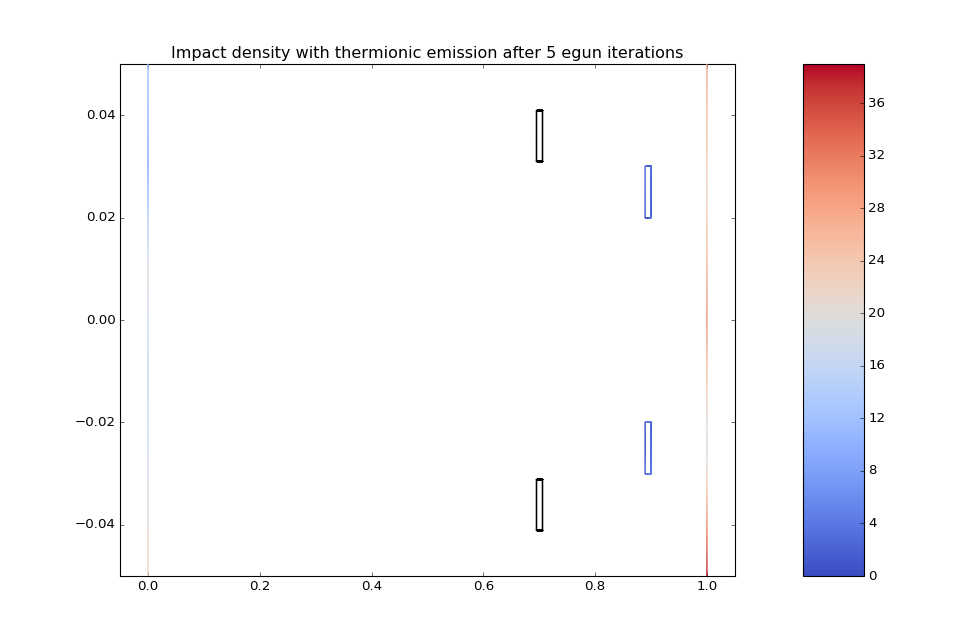

In [39]:
fig = plt.figure(figsize = (12,8))

gs = gridspec.GridSpec(1, 2,width_ratios=[1,0.1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title('Impact density with thermionic emission after {} egun iterations'.format(ITERATIONS))

ax1.set_ylim(w3d.xmmin*1e6,w3d.xmmax*1e6)
ax1.set_xlim(-0.05, 1.05)
IDP = ImpactDensity.PlotDensity(ax1,ax2, scraper, top, w3d)
IDP()

#fig.savefig('egun_{}iterations.pdf'.format(ITERATIONS),bbox_inches='tight')